In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar,minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
from multiprocessing import Process,Queue,Pool
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import pickle as pkl
import importlib
from matplotlib.backends.backend_pdf import PdfPages
import sys
sys.path.append("../src/")
from flux_finding_mp import *
rd.seed(1000)
np.random.seed(1000)
from functools import partial
import seaborn as sb

In [2]:
cellType = "RAS0mM2DG" #RAS PC3 DITNC1 SC P 0.75mM2DG 2mM2DG 5mM2DG 10mM2DG
numCores = 10
numBestFitIters = 300
numMonteCarloIters = 500
numMonteCarloIters_downsample = 200

In [3]:
concentration = pd.read_csv("../data/concentrations.csv",index_col=0)
excret = pd.read_csv("../data/excretion_flux.csv",index_col=0)
lacEx = excret.at[cellType,"lactate_excretion_fmol_cell_min"]
gluUp = excret.at[cellType,"glucose_uptake_fmol_cell_min"]
concs = {met:val for met,val in zip(concentration.columns.values,concentration.loc[cellType,:].values)}
print(concs)
print(lacEx,gluUp)

{'NAD(H)': 0.764658647, 'Malate': 4.2573125, 'G3P': 0.25825, 'Lactate': 93.71755208}
18.23297952 15.66486568


[ 0  0  0  1  1  1  3  3  3  5  5  5 10 10 10 20 20 20 30 30 30]


,UL_malate,UL_g3p,UL_lac,UL_gap,UL_nadh
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.956406,0.938803,0.970926,0.862616,0.919650
4,0.961825,0.964342,0.981026,0.876542,0.899523
5,0.935526,0.902373,0.952959,0.810298,0.848162
6,0.853240,0.810328,0.924061,0.734017,0.757145
7,0.880619,0.851546,0.961358,0.765121,0.763433
8,0.889207,0.863027,0.948814,0.765694,0.801603
9,0.866131,0.842678,0.935563,0.733610,0.784901


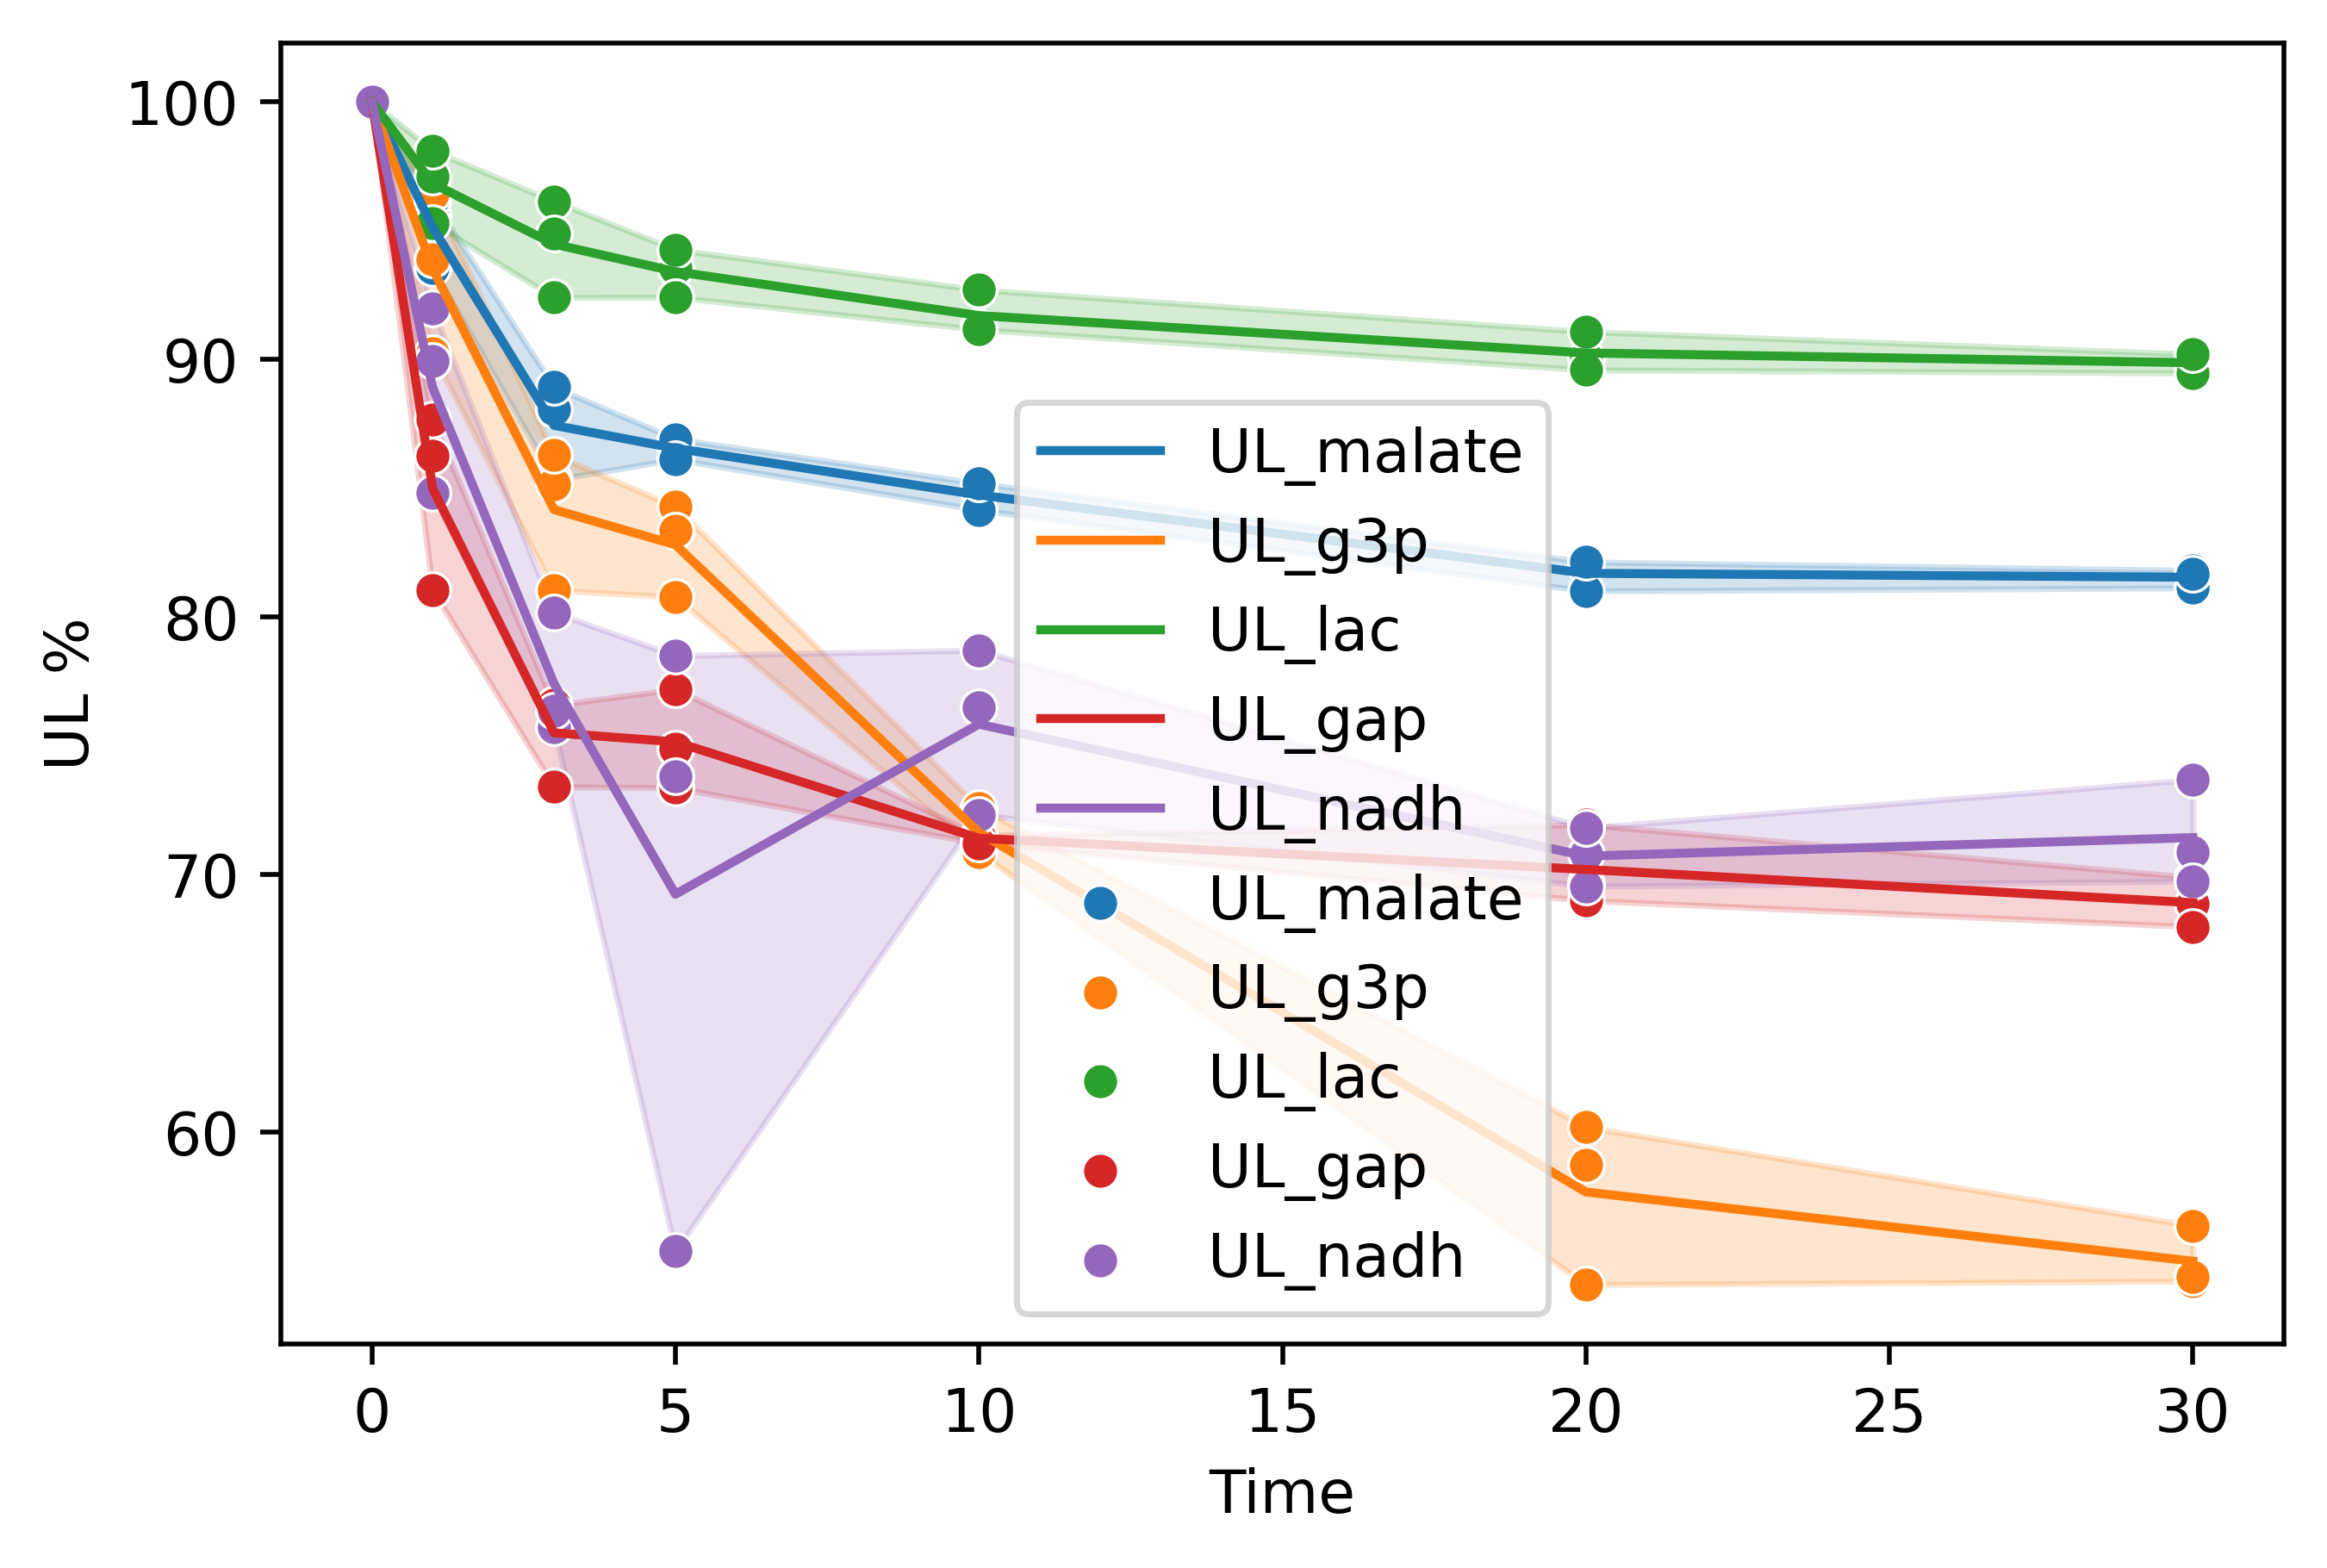

In [4]:
data = pd.read_csv("../data/" + cellType + "/" + cellType+".csv")
data = data[["Time","UL_malate","UL_g3p","UL_lac","UL_gap","UL_nadh"]]
for val in data.columns.values[1:]:
    sb.lineplot(data=data,x="Time",y=val,label=val)
plt.legend()
for val in data.columns.values[1:]:
    sb.scatterplot(data=data,x="Time",y=val,label=val)
plt.ylabel("UL %")

t = data["Time"].values
data = data[data.columns.values[1:]]
data = data/100
conc = concs
print(t)
data

finding best fit |██████████████████████████████████████████████████| 100.0% 


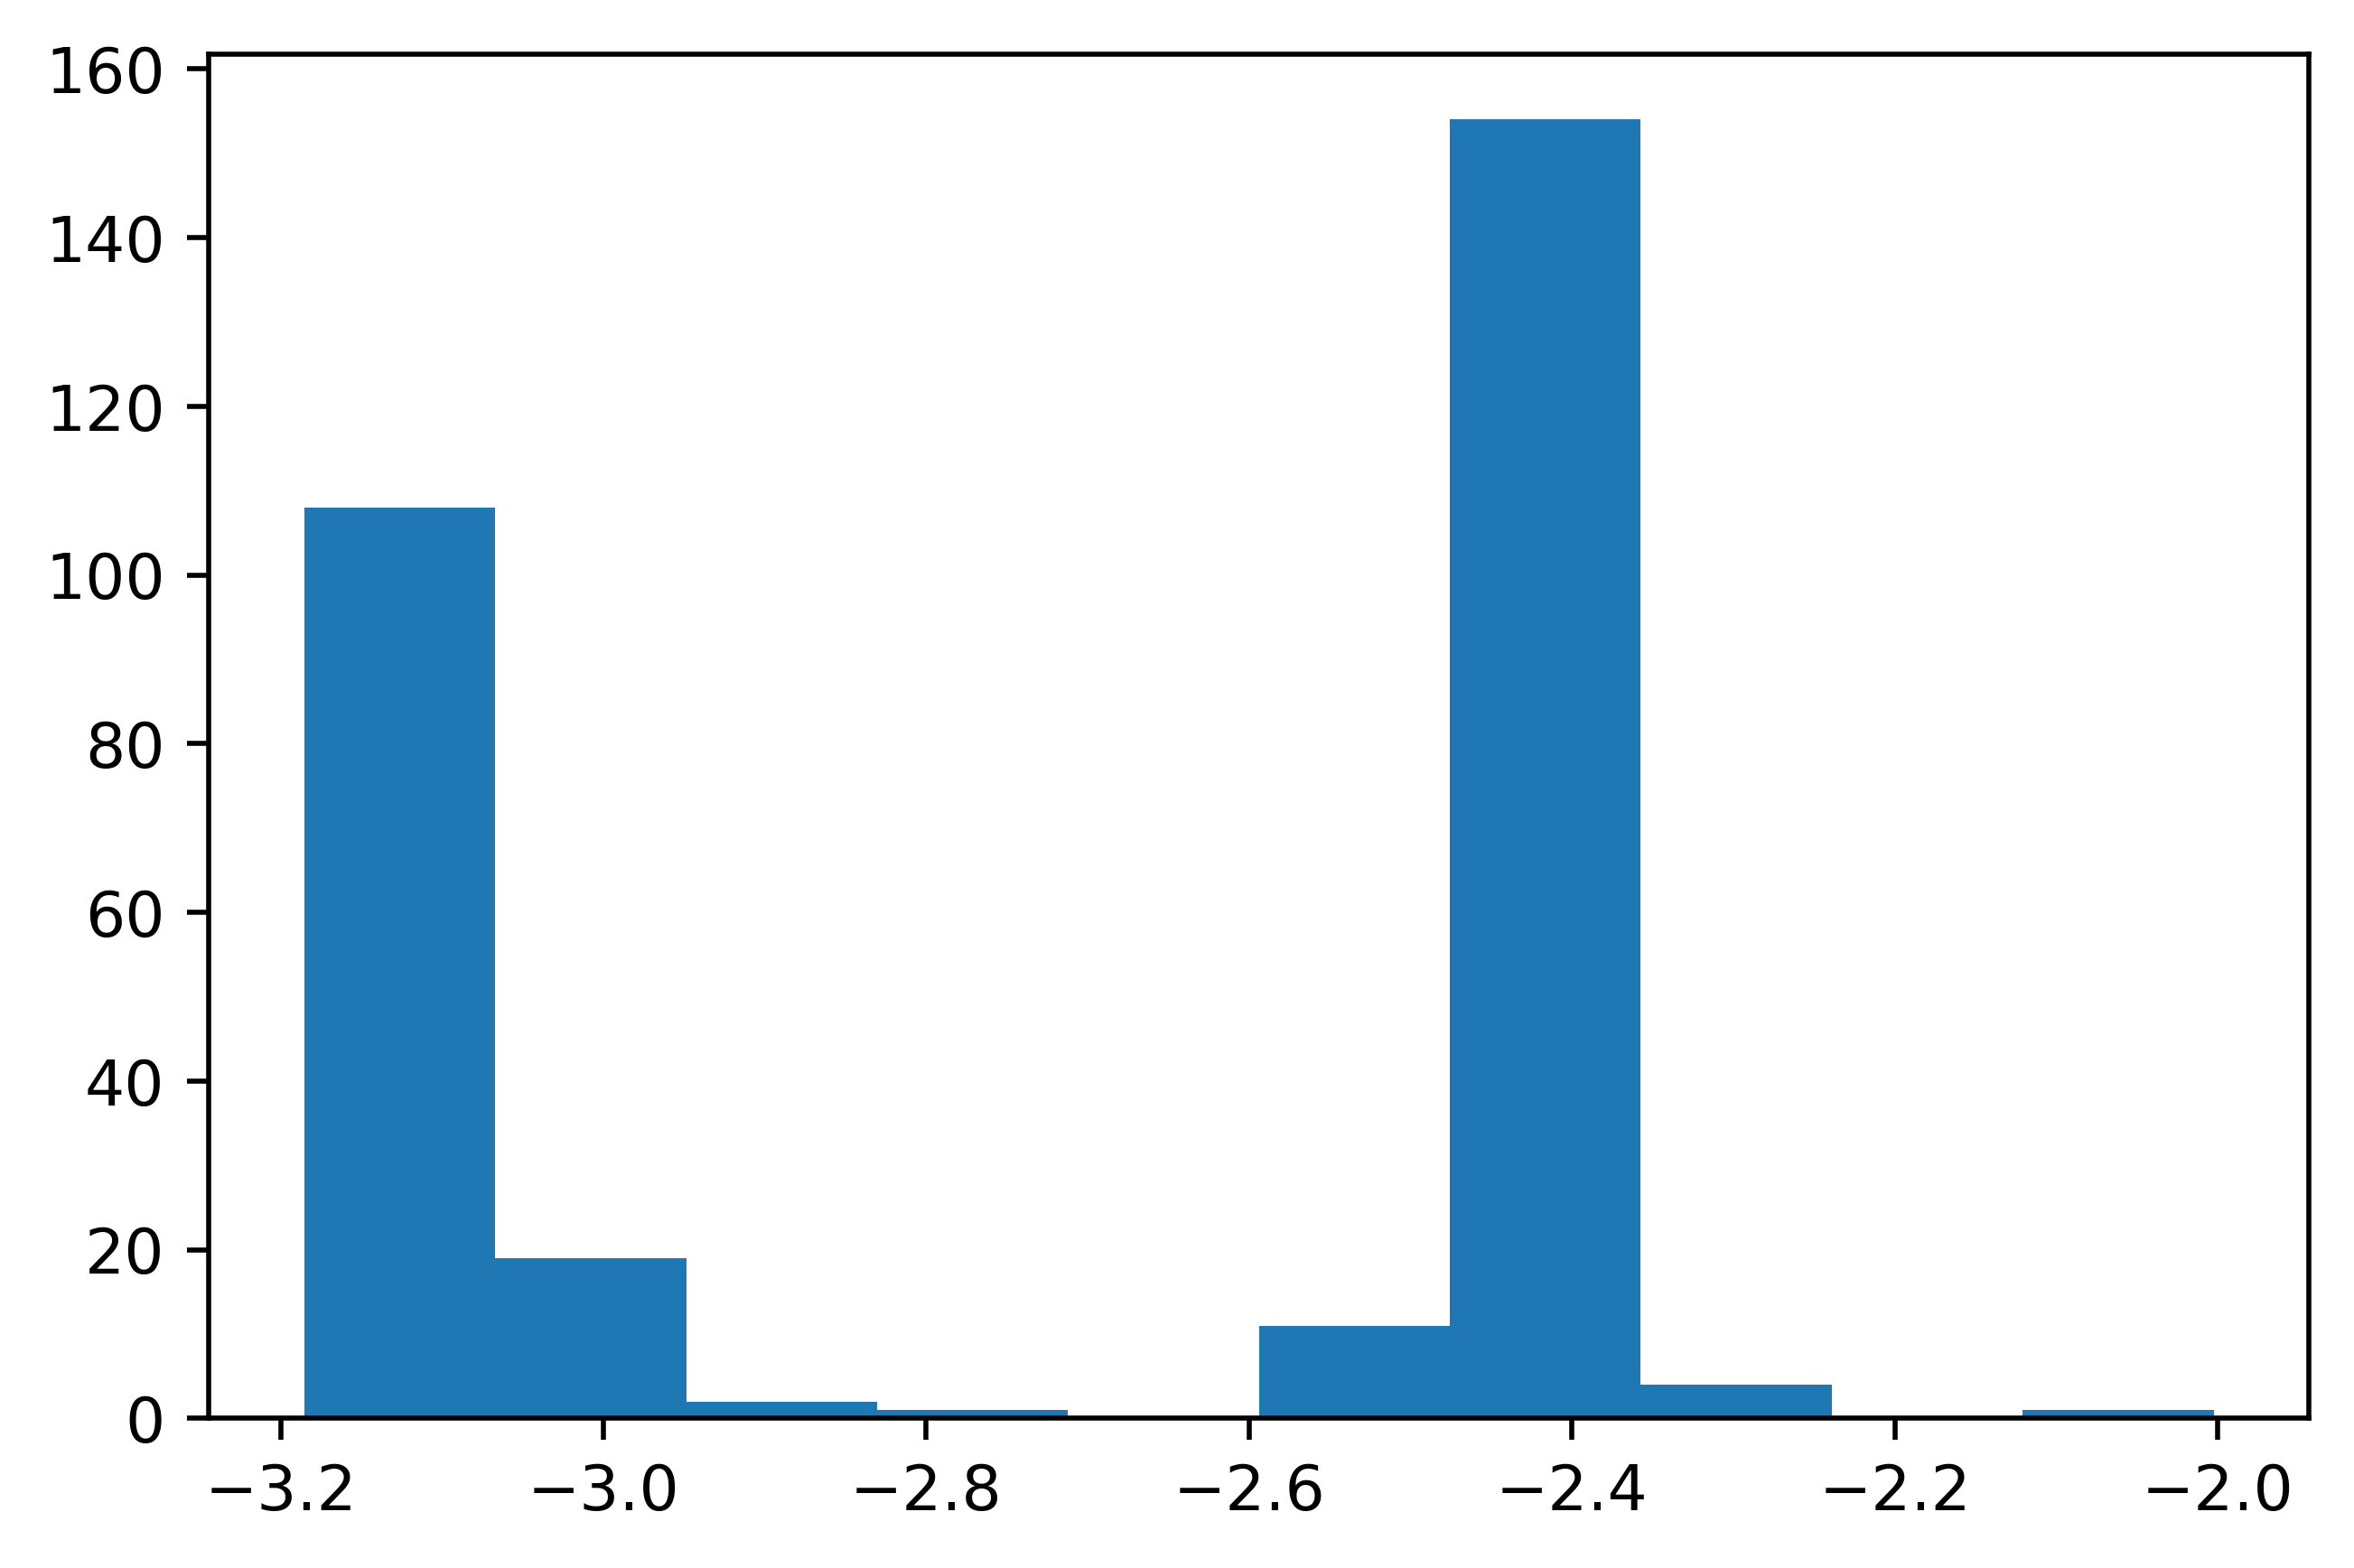

In [5]:
if __name__ == '__main__':
    rd.seed(1000)
    np.random.seed(1000)
    args = [[data,t,conc,lacEx,gluUp,np.random.random(7)] for _ in range(numBestFitIters)]
    startingParams = startConcurrentTask(findFlux,args,numCores,"finding best fit",len(args))
    startingParams = [x for x in startingParams if type(x) != type(-1)]
    plt.hist([[np.log10(x[-1]) for x in startingParams]])
    startingParams.sort(key=lambda x: x[-1])
    plt.show()


In [6]:
bestParams = startingParams[0]
print(bestParams) #fluxes are in order of paper (glycolytic, unlabled malate source, MAS, G3PS, unlabeled G3P shuttle, LDH, unlabeled lactate source) )

[1.48163233e+01 3.14481288e+00 4.70763479e+00 3.55219891e-02
 3.56272044e-03 6.56503177e+00 1.16679477e+01 6.52676283e-04]


In [ ]:
if __name__ == '__main__':
    allFluxes = runMonteCarlo(data,t,conc,lacEx,gluUp,bestParams[:-1],numMonteCarloIters,numCores)

resampling datasets |██████████████████████████████████████████████████| 100.0% 
running monte carlo |██████████████████████████████--------------------| 60.0% 

In [ ]:
pkl.dump([allFluxes,bestParams],open("../data/" + str(cellType) + "/" + cellType + ".pkl","wb"))

#[allFluxes,bestParams] = pkl.load(open("../data/" + str(cellType) + "/" + cellType + ".pkl","rb"))

[interval,intervalParams,allFluxes] = removeBadSol(allFluxes,ci=95,cutoff=2*bestParams[-1],target=numMonteCarloIters_downsample)



In [ ]:
t_t = np.linspace(0,3*max(t),100)
print(bestParams)
"""
[ 8.07073753e-01  5.64266110e-02  5.61447969e-01  9.84776390e-01
  7.34287184e-01  2.11647608e-01 -1.39103625e-01  6.54110283e-01
  8.11174172e-04]

"""


In [ ]:
outdict = {"MDH":{"bestFit":bestParams[2],"LB":interval[2][0],"UB":interval[2][1]},
           "GPD":{"bestFit":bestParams[3],"LB":interval[3][0],"UB":interval[3][1]},
           "LDH":{"bestFit":bestParams[5],"LB":interval[5][0],"UB":interval[2][1]},
          "SSE":{"bestFit":bestParams[-1],"LB":None,"UB":None}}
outdict = pd.DataFrame.from_dict(outdict,orient="index")
outdict.to_csv("../data/" + cellType + "/" + cellType + "_fluxes.csv")
outdict

In [ ]:
dhap_params = fitSource(t, data["UL_gap"])
nadh_params = fitSource(t, data["UL_nadh"])
firstT = np.min(t)
firstT = [x for x in range(len(t)) if abs(firstT-t[x]) < 1e-5]
initialState = [np.mean(data.loc[firstT,label])*c for label,c in zip(["UL_lac","UL_g3p","UL_malate"],[conc["Lactate"],conc["G3P"],conc["Malate"]])]
predictedL = integrateLabelingModel(t_t,bestParams[:-1],conc,dhap_params,nadh_params,initialState)

In [ ]:
names = ["Lac","G3P","Mal"]


plt.scatter(t,data["UL_nadh"])
plt.plot(t_t,exponetialCurve(t_t,nadh_params))
plt.title("NADH")



plt.figure()
plt.plot(t_t,exponetialCurve(t_t,dhap_params))
plt.title("Ga3P")
plt.scatter(t,data["UL_gap"])

pos = 0
for x,label in zip([5,3,2],["UL_lac","UL_g3p","UL_malate"]):
  print(interval[x])
  fig = plt.figure()
  predictedMaxL = integrateLabelingModel(t_t,intervalParams[x][1],conc,dhap_params,nadh_params,initialState)
  predictedMinL = integrateLabelingModel(t_t,intervalParams[x][0],conc,dhap_params,nadh_params,initialState)
  #predictedMaxL = integrateLabelingModel(t_t,intervalParams[x][1][:3],np.append(conc[:-1],intervalParams[x][1][5:6]),intervalParams[x][1][6:-1],intervalParams[x][1][3:5])
  #predictedMinL = integrateLabelingModel(t_t,intervalParams[x][0][:3],np.append(conc[:-1],intervalParams[x][0][5:6]),intervalParams[x][0][6:-1],intervalParams[x][0][3:5])
  plt.scatter(t,data[label])
  plt.plot(t_t,predictedL[:,pos],label="Estimate")
  plt.plot(t_t,predictedMaxL[:,pos],label="Max")
  plt.plot(t_t,predictedMinL[:,pos],label="Min")
  plt.legend()

  plt.xlabel("t")
  plt.ylabel("Unlabeled Percentage")
  plt.title(names[pos] + "  95% Confidence Interval = " + str(np.round(interval[x][0],2))+ "-" + str(np.round(interval[x][1],2)))

  plt.ylim((.5,1.0))
  pos += 1
    
plt.show()



In [ ]:
names = ["MAS","G3PS","LDH"]
plt.rcParams["font.weight"] = 500
plt.rcParams["axes.labelweight"] = 500
uniqueTs = list(set(t))
uniqueTs.sort()
#pp = PdfPages(cellType + '.pdf')
limits = [(40,100),(40,100),(40,100)]
colors = ["Grey","Blue","Red"]
fig,ax = plt.subplots(figsize=(3,3))
pos = 0
for x,label,color in zip([2,1,0],["UL_malate","UL_g3p","UL_lac"],colors):
  data2Plot = {tt:[] for tt in uniqueTs}
  tmp = pd.DataFrame(data)
  tmp["t"] = t
  for tt in uniqueTs:
        filt = tmp[tmp["t"] == tt]
        data2Plot[tt] = filt[label].values
        
  #for tt,ll in zip(t,p[:,x+1]):
  #      data2Plot[tt].append(ll)
  ydata = [100*np.mean(data2Plot[tt]) for tt in uniqueTs]
  yerr = [100*np.std(data2Plot[tt])/np.sqrt(len(data2Plot[tt])) for tt in uniqueTs] 
  
  #print(intervalParams[x])
  #integrateLabelingModel(t_t,intervalParams[x][0][:3],conc,intervalParams[x][0][6:],intervalParams[x][0][3:6])
  plt.errorbar(uniqueTs,ydata,yerr=yerr,fmt="o",capsize=2,color=color,capthick=.35,markersize=3,elinewidth=0.5)
  plt.plot(t_t,[100*i for i in predictedL[:,x]],label=names[pos],color=color,linewidth=1.7)
 
  #plt.xlabel("Time (minutes)",fontname="Arial",fontsize=16,color='black')
  plt.xlabel("Time (minutes)",fontsize=16,color='black')
  plt.ylabel("Unlabeled enrichment (%)",fontsize = 16,fontname = "Arial",color='black')
  #plt.title(names[x+1] + " Flux = " + str(np.round(bestParams[x],2)) + " 95% CI = [" + str(np.round(interval[x][0],2))+ "," + str(np.round(interval[x][1],2)) + "]")
  #plt.title(names[x+1],fontsize=10,fontname = "Arial") 
  plt.xlim((0,40))
  plt.ylim(limits[x])
  fig.tight_layout()
  pos += 1

ax=plt.gca();
ax.spines['bottom'].set_linewidth(1.7);
ax.spines['left'].set_linewidth(1.7);
plt.tick_params(labelsize=17)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

axis = plt.gca().xaxis
#axis.get_ticklabels()  
#axis.get_ticklines()  
for label in axis.get_ticklabels():
    label.set_color('black')          
    label.set_fontsize(17)          
for line in axis.get_ticklines():
    line.set_color('black')
    line.set_markersize(6)         
    line.set_markeredgewidth(2)     
    
axis = plt.gca().yaxis
#axis.get_ticklabels()  
#axis.get_ticklines()  
for label in axis.get_ticklabels():
    label.set_color('black')          
    label.set_fontsize(17)          
for line in axis.get_ticklines():
    line.set_color('black')
    line.set_markersize(6)         
    line.set_markeredgewidth(2)     
    




right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.legend(frameon=False) 
plt.savefig("../data/" + cellType + "/" + cellType + ".png")
#pp.savefig(fig)
#pp.savefig(fig)






In [ ]:
names = ["MAS","G3P","LAC"]


uniqueTs = list(set(t))
uniqueTs.sort()
pp = PdfPages("../data/" + cellType + "/" + cellType + '.pdf')
limits = [(70,100),(50,100),(80,100)]
#colors = ["Grey","dodgerblue","Red"]
pos = 0
for x,label in zip([2,1,0],["UL_malate","UL_g3p","UL_lac"]):
  data2Plot = {tt:[] for tt in uniqueTs}
  tmp = pd.DataFrame(data)
  tmp["t"] = t
  for tt in uniqueTs:
        filt = tmp[tmp["t"] == tt]
        data2Plot[tt] = filt[label].values
  ydata = [100*np.mean(data2Plot[tt]) for tt in uniqueTs]
  yerr = [100*np.std(data2Plot[tt]) for tt in uniqueTs] 
  fig = plt.figure(figsize=(4,4))
  
  plt.errorbar(uniqueTs,ydata,yerr=yerr,fmt="o",capsize=2,color="black",capthick=.35,markersize=2,elinewidth=.50)
  
  plt.plot(t_t,[100*i for i in predictedL[:,x]],label=names[pos],color="black",linewidth=.50)
 
  plt.xlabel("time (minutes)",fontname="Arial",fontsize=10)
  plt.ylabel("unlabeled percentage (%)",fontsize = 10,fontname = "Arial")
  plt.title(names[pos],fontsize=10,fontname = "Arial") 
  plt.xlim((0,40))
  plt.ylim(limits[x])
  fig.tight_layout()
  pp.savefig(fig)
  pos += 1

pp.close()
plt.show()


In [ ]:
# delta = .001
# for f,i in zip(bestParams[:-1],range(len(bestParams[:-1]))):
#     x0 = predictedL
#     tempFlux = list(bestParams)
#     tempFlux[i] += delta*tempFlux[i]
#     integrateLabelingModel(t_t,bestParams[:3],np.append(conc[:-1],bestParams[5:6]),bestParams[6:-1],bestParams[3:5])
#     x1 = integrateLabelingModel(t_t,tempFlux[:3],np.append(conc[:-1],tempFlux[5:6]),tempFlux[6:-1],tempFlux[3:5])
#     tempFlux = list(bestParams)
#     tempFlux[i] -= delta*tempFlux[i]
#     x2 = integrateLabelingModel(t_t,tempFlux[:3],np.append(conc[:-1],tempFlux[5:6]),tempFlux[6:-1],tempFlux[3:5])
#     diff1 = np.abs(np.subtract(x0,x1))
#     diff2 = np.abs(np.subtract(x0,x2))
#     diff = (diff1 + diff2)/2
#     diff = np.sum(diff)/diff.size
#     sensitivity = diff/(delta*tempFlux[i])
#     print(sensitivity)